In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import librosa
from sklearn.decomposition import PCA
import torch
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from scipy.spatial import distance
from scipy.spatial.distance import cosine

### Function to create MFCC coefficients

In [2]:
def create_MFCC_coefficients(file_name):
    sr_value = 44100
    n_mfcc_count = 20
    try:
        y, sr = librosa.load(file_name, sr=sr_value)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc_count)
        coeff_df = pd.DataFrame(mfccs)
        return coeff_df.T
    except:
        return None

## GTZAN data for pretraining 

In [3]:
L = 2584
gtzan_Data = []
gtzan_Label = []
scaler = MinMaxScaler()
folder_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
folder_names = os.listdir(folder_path)

for folder in folder_names:
    file_names = os.listdir(os.path.join(folder_path, folder))
    for file in file_names:
        file_path = os.path.join(folder_path, folder, file)
        mfcc_data = create_MFCC_coefficients(file_path) 
        if mfcc_data is not None:
            delta_mfcc = librosa.feature.delta(mfcc_data)
            delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
            interleaved_mfcc = np.empty((mfcc_data.shape[1] * 3, mfcc_data.shape[0]))
            for i in range(mfcc_data.shape[1]):
                interleaved_mfcc[i * 3] = mfcc_data[i]
                interleaved_mfcc[i * 3 + 1,:] = delta_mfcc[:,i]
                interleaved_mfcc[i * 3 + 2,:] = delta2_mfcc[:,i]
            mfcc_data_scaled = scaler.fit_transform(interleaved_mfcc).T

            if len(mfcc_data_scaled) < L:
                padding = L - len(mfcc_data_scaled)
                mfcc_data_scaled = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
            elif len(mfcc_data_scaled) > L:
                mfcc_data_scaled = mfcc_data_scaled[:L, :]

            gtzan_Data.append(np.array(mfcc_data_scaled))
            gtzan_Label.append(folder)

/tmp/ipykernel_30/1861942266.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=sr_value)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


<Axes: >

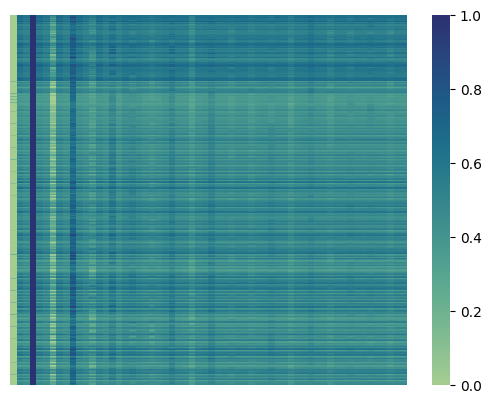

In [4]:
sns.heatmap(gtzan_Data[0],cmap='crest', xticklabels=False, yticklabels=False)

<Axes: >

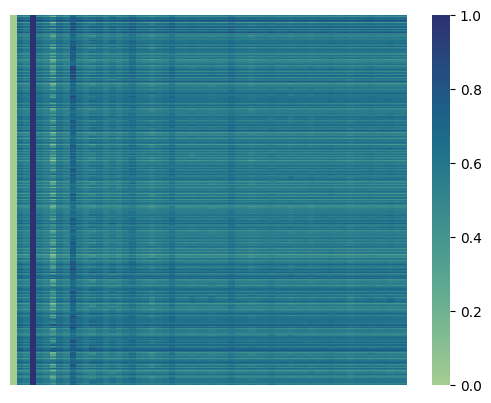

In [5]:
sns.heatmap(gtzan_Data[2],cmap='crest', xticklabels=False, yticklabels=False)

In [6]:
label_encoder = LabelEncoder()
gtzan_Label = label_encoder.fit_transform(gtzan_Label)

In [7]:
def create_sandwiched_vgg19(input_shape=(2584, 60, 1), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(128, (3, 3), padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.MaxPooling2D((8, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.MaxPooling2D((8, 2))(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.Conv2D(3, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.UpSampling2D(size=(8, 8))(x)
    base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(320, 120, 3))
    base_model.trainable = False
    x = base_model(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

model = create_sandwiched_vgg19()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2584, 60, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2584, 60, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2584, 60, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 323, 30, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 323, 30, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 323, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 15, 3)      │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 40, 15, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 320, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 10, 3, 512)     │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,053,773 (91.76 MB)

 Trainable params: 4,029,389 (15.37 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [8]:
Data = np.array(gtzan_Data)
labels = np.array(gtzan_Label)
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.1, random_state=42)

In [9]:
model.fit(X_train,y_train,epochs = 50,batch_size = 32,validation_split = 0.2)

Epoch 1/50


I0000 00:00:1730834163.945939     113 service.cc:145] XLA service 0x7907812ee640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730834163.945994     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730834183.973602     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.0933 - loss: 4.8245 - val_accuracy: 0.0833 - val_loss: 2.4287
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.0927 - loss: 2.3392 - val_accuracy: 0.1556 - val_loss: 2.3006
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.1588 - loss: 2.2811 - val_accuracy: 0.1111 - val_loss: 2.2619
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.1614 - loss: 2.2011 - val_accuracy: 0.2056 - val_loss: 2.1530
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.2153 - loss: 2.1343 - val_accuracy: 0.1833 - val_loss: 2.1554
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.2591 - loss: 2.0168 - val_accuracy: 0.2611 - val_loss: 1.9412
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.2967 - loss: 1.8462 - val_accuracy: 0.2833 - val_loss: 1.9382
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.3424 - loss: 1.7576 - val_accuracy: 0.3111 - val_lo

In [10]:
loss , accuracy = model.evaluate(X_test,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 861ms/step - accuracy: 0.4465 - loss: 1.9977


## Fine tuning on our data

In [11]:
L = 2584  # Target number of frames
Data = []
Label = []
scaler = MinMaxScaler()
folder_path = '/kaggle/input/ds203-songs'
folder_names = os.listdir(folder_path)

for folder in folder_names:
    folder__names = os.listdir(os.path.join(folder_path, folder))
    for folder_ in folder__names:
        file_names = os.listdir(os.path.join(folder_path, folder, folder_))
        for file in file_names:
            file_path = os.path.join(folder_path, folder, folder_, file)
            mfcc_data = create_MFCC_coefficients(file_path)  # Ensure this function is defined
            
            if mfcc_data is not None:
                delta_mfcc = librosa.feature.delta(mfcc_data)
                delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
                interleaved_mfcc = np.empty((mfcc_data.shape[1] * 3, mfcc_data.shape[0]))
                for i in range(mfcc_data.shape[1]):
                    interleaved_mfcc[i * 3] = mfcc_data[i]
                    interleaved_mfcc[i * 3 + 1, :] = delta_mfcc[:, i]
                    interleaved_mfcc[i * 3 + 2, :] = delta2_mfcc[:, i]
                
                mfcc_data_scaled = scaler.fit_transform(interleaved_mfcc).T
                num_segments = len(mfcc_data_scaled) // L
                if len(mfcc_data_scaled) >= L:
                    for i in range(num_segments):
                        segment = mfcc_data_scaled[i * L : (i + 1) * L, :]
                        Data.append(np.array(segment))
                        Label.append(folder_)
                else:
                    padding = L - len(mfcc_data_scaled)
                    mfcc_data_scaled_padded = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
                    Data.append(np.array(mfcc_data_scaled_padded))
                    Label.append(folder_)

<Axes: >

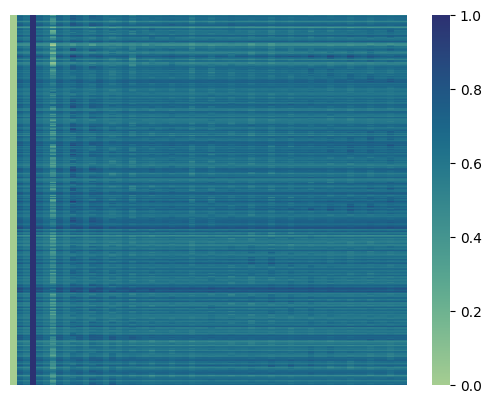

In [12]:
sns.heatmap(Data[3],cmap='crest', xticklabels=False, yticklabels=False)

In [13]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(Label)

In [14]:
Feature_extractor = Model(inputs=model.input,outputs=model.get_layer('dense').output)

In [15]:
x = layers.Dropout(0.15)(Feature_extractor.output)
x = layers.Dense(6, activation='softmax')(x)
fine_tuned_model = Model(inputs=Feature_extractor.input, outputs=x)
fine_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fine_tuned_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2584, 60, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2584, 60, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2584, 60, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 323, 30, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 323, 30, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 323, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 15, 3)      │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 40, 15, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 320, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 10, 3, 512)     │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,052,745 (91.75 MB)

 Trainable params: 4,028,361 (15.37 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
Data = np.array(Data)
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.2, random_state=42)

In [17]:
fine_tuned_model.fit(X_train,y_train,epochs = 10,batch_size = 32,validation_split = 0.2)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1732 - loss: 16.3882 - val_accuracy: 0.3214 - val_loss: 4.6797
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.3264 - loss: 7.7942 - val_accuracy: 0.5143 - val_loss: 2.9697
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.4121 - loss: 5.0483 - val_accuracy: 0.5214 - val_loss: 2.9802
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.4638 - loss: 3.6433 - val_accuracy: 0.5357 - val_loss: 1.3643
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.5316 - loss: 2.4908 - val_accuracy: 0.6429 - val_loss: 1.1133
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - accuracy: 0.5517 - loss: 2.0029 - val_accuracy: 0.5714 - val_loss: 1.8651
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.6274 - loss: 1.8224 - val_accuracy: 0.5357 - val_loss: 1.9207
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.5931 - loss: 2.0895 - val_accuracy: 0.6

In [18]:
loss , accuracy = model.evaluate(X_test,y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.0037 - loss: 7.7785   


## Predicting for the given data

In [19]:
scaler = MinMaxScaler()
folder_path = '/kaggle/input/ds203-v2-dataset/MFCC-files-v2-20241024'
file_names = os.listdir(folder_path)
Data = []
meta_data = []
L = 2584  # Target number of frames

for file in file_names:
    file_path = os.path.join(folder_path, file)
    meta_data.append(file)
    df = pd.read_csv(file_path, header=None)
    mfcc_data = df.T
    delta_mfcc = librosa.feature.delta(mfcc_data)
    delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
    interleaved_mfcc = np.empty((mfcc_data.shape[1] * 3, mfcc_data.shape[0]))
    for i in range(mfcc_data.shape[1]):
        interleaved_mfcc[i * 3] = mfcc_data[i]
        interleaved_mfcc[i * 3 + 1,:] = delta_mfcc[:,i]
        interleaved_mfcc[i * 3 + 2,:] = delta2_mfcc[:,i]
    mfcc_data_scaled = scaler.fit_transform(interleaved_mfcc).T
    if len(mfcc_data_scaled) < L:
        padding = L - len(mfcc_data_scaled)
        mfcc_data_scaled = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
    elif len(mfcc_data_scaled) > L:
        mfcc_data_scaled = mfcc_data_scaled[:L, :]
    Data.append(mfcc_data_scaled)
Data = np.array(Data)
meta_data = np.array(meta_data)

In [20]:
predictions = fine_tuned_model.predict(Data)
predicted_labels = predictions.argmax(axis=1)
original_labels = label_encoder.inverse_transform(predicted_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step


In [21]:
result_df = pd.DataFrame({'Label': original_labels, 'MetaData': meta_data})
result_df.to_csv('result.csv', index=False)
result_df.head()

,Label,MetaData
0,Asha_Bhosale,70-MFCC.csv
1,Asha_Bhosale,104-MFCC.csv
2,Asha_Bhosale,67-MFCC.csv
3,Asha_Bhosale,110-MFCC.csv
4,Asha_Bhosale,92-MFCC.csv


In [22]:
Feature_extractor = Model(inputs=fine_tuned_model.input,outputs=fine_tuned_model.get_layer('dense').output)

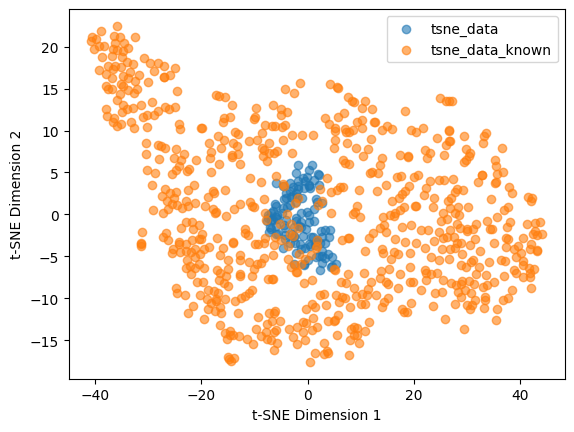

In [23]:
Features = []
for i in range(len(Data)):
    Features.append(Feature_extractor(Data[i].reshape(1,2584,60,1))[0])
Features_known = []
for i in range(len(X_train)):
    Features_known.append(Feature_extractor(X_train[i].reshape(1,2584,60,1))[0])
Features = np.array(Features)
Features_known = np.array(Features_known)
model = TSNE(n_components = 2, random_state = 0)
tsne_data = model.fit_transform(Features)
tsne_data_known = model.fit_transform(Features_known)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], label="tsne_data", alpha=0.6)
plt.scatter(tsne_data_known[:, 0], tsne_data_known[:, 1], label="tsne_data_known", alpha=0.6)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

### Clustering the Given Data

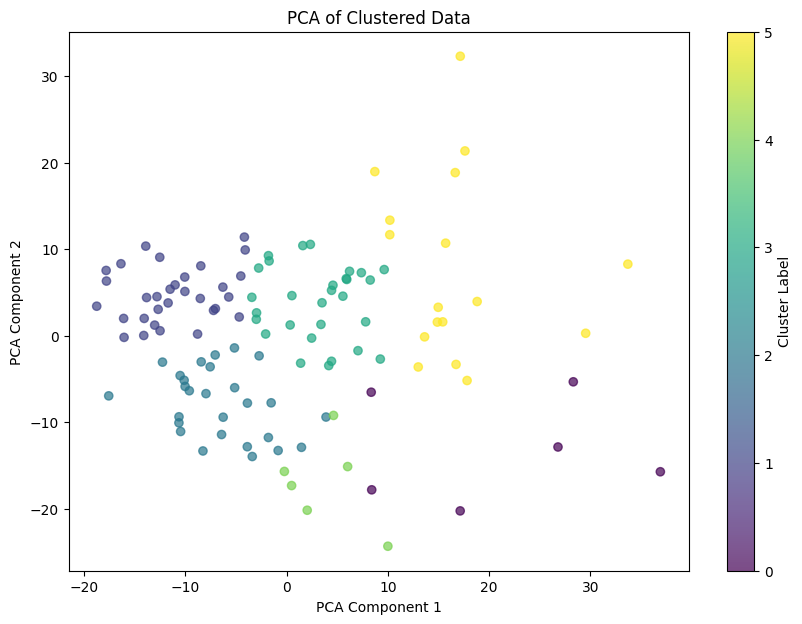

In [24]:
kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(Features)
Cluster_label = kmeans.labels_
pca = PCA(n_components=2)
features_pca = pca.fit_transform(Features)

# Plotting
plt.figure(figsize=(10, 7))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=Cluster_label, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")  
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Clustered Data")
plt.show()

In [25]:
result_df = pd.DataFrame({'CLuster_Label': Cluster_label, 'MetaData': meta_data})
result_df.to_csv('Cluster.csv', index=False)
result_df.head()

,CLuster_Label,MetaData
0,5,70-MFCC.csv
1,5,104-MFCC.csv
2,2,67-MFCC.csv
3,4,110-MFCC.csv
4,2,92-MFCC.csv


### Identifying k closest vectors

In [26]:
Asha_Bhosale_path = '/kaggle/input/ds203-songs/Asha_Bhosale-20241030T093033Z-001/Asha_Bhosale/Aaj_Tere_Piya_Ki_Talash_Ho_Rahi_Hai_-_Mahasati_Savitri_128_Kbps.mp3'
Michael_Jackson_path = '/kaggle/input/ds203-songs/Michael Jackson-20241030T093047Z-001/Michael Jackson/bad.mp3'
kishor_kumar_path = '/kaggle/input/ds203-songs/KISHORE_KUMAR-20241030T093039Z-001/KISHORE_KUMAR/oldKalakaar-Neele Neele Ambar.mp3'
jan_gan_man_path = '/kaggle/input/ds203-songs/Jan Gan Man-20241030T093036Z-001/Jan Gan Man/jan-gan-man-adhinayak-jai-hai-full-song--by-priyanka-chopra.mp3'
marth_lavan_path = '/kaggle/input/ds203-songs/MARATHI_LAVNI/MARATHI_LAVNI/Aase Wajwa Ki  Dholki  Siddharth Jadhav, Manasi Naik andLavani Mandali.mp3'
marth_bhav_path = '/kaggle/input/ds203-songs/Marathi Bhav Geet Songs/Marathi Bhav Geet Songs/Aali Kuthun Shi Kani Taal Mrudungachi Dhun- Vasant Azgaonkar, Bhaktigeet.mp3'
def read(file_path,start,end):
    mfcc_data = create_MFCC_coefficients(file_path) 
    if mfcc_data is not None:
        delta_mfcc = librosa.feature.delta(mfcc_data)
        delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
        interleaved_mfcc = np.empty((mfcc_data.shape[1] * 3, mfcc_data.shape[0]))
        for i in range(mfcc_data.shape[1]):
            interleaved_mfcc[i * 3] = mfcc_data[i]
            interleaved_mfcc[i * 3 + 1,:] = delta_mfcc[:,i]
            interleaved_mfcc[i * 3 + 2,:] = delta2_mfcc[:,i]
        mfcc_data_scaled = scaler.fit_transform(interleaved_mfcc).T

        if len(mfcc_data_scaled) < L:
            padding = L - len(mfcc_data_scaled)
            mfcc_data_scaled = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
        elif len(mfcc_data_scaled) > L:
            mfcc_data_scaled = mfcc_data_scaled[start:end, :]
        return mfcc_data_scaled
Asha_Bhosale = Feature_extractor(read(Asha_Bhosale_path,13502,16086).reshape(1,2584,60,1))[0]
Michael_Jackson = Feature_extractor(read(Michael_Jackson_path,0,L).reshape(1,2584,60,1))[0]
kishor_kumar = Feature_extractor(read(kishor_kumar_path,2322,4906).reshape(1,2584,60,1))[0]
jan_gan_man = Feature_extractor(read(jan_gan_man_path,0,L,).reshape(1,2584,60,1))[0]
marth_lavan = Feature_extractor(read(marth_lavan_path,3440,6024).reshape(1,2584,60,1))[0]
marth_bhav = Feature_extractor(read(marth_bhav_path,1290,3874).reshape(1,2584,60,1))[0]
vectors = {
    "Asha_Bhosale": Asha_Bhosale,
    "Michael_Jackson": Michael_Jackson,
    "kishor_kumar": kishor_kumar,
    "jan_gan_man": jan_gan_man,
    "marth_lavan": marth_lavan,
    "marth_bhav": marth_bhav
}

In [27]:
def top_k_closest_cosine(vectors, target_vector, k=10):
    similarities = [1 - distance.cosine(target_vector, vec) for vec in vectors]
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return top_k_indices
A = top_k_closest_cosine(Features,Asha_Bhosale)
M = top_k_closest_cosine(Features,Michael_Jackson)
K = top_k_closest_cosine(Features,kishor_kumar)
J = top_k_closest_cosine(Features,jan_gan_man)

In [28]:
A = meta_data[A]
M = meta_data[M]
K = meta_data[K]
J = meta_data[J]

In [29]:
print(A,M,K,J)

['25-MFCC.csv' '36-MFCC.csv' '65-MFCC.csv' '46-MFCC.csv' '79-MFCC.csv'
 '72-MFCC.csv' '07-MFCC.csv' '19-MFCC.csv' '28-MFCC.csv' '42-MFCC.csv'] ['11-MFCC.csv' '20-MFCC.csv' '53-MFCC.csv' '39-MFCC.csv' '64-MFCC.csv'
 '113-MFCC.csv' '55-MFCC.csv' '81-MFCC.csv' '114-MFCC.csv' '37-MFCC.csv'] ['32-MFCC.csv' '85-MFCC.csv' '37-MFCC.csv' '62-MFCC.csv' '76-MFCC.csv'
 '24-MFCC.csv' '113-MFCC.csv' '75-MFCC.csv' '57-MFCC.csv' '86-MFCC.csv'] ['90-MFCC.csv' '02-MFCC.csv' '16-MFCC.csv' '17-MFCC.csv' '35-MFCC.csv'
 '87-MFCC.csv' '01-MFCC.csv' '74-MFCC.csv' '68-MFCC.csv' '95-MFCC.csv']


### Labelling Clusters

In [30]:
Centroid = kmeans.cluster_centers_
print(Centroid.shape)
cluster_labels = {}
for i in range(len(Centroid)):
    target_vector = Centroid[i]
    closest_name = None
    closest_similarity = -1  
    for name, vector in vectors.items():
        similarity = 1 - cosine(target_vector, vector) 
        if similarity > closest_similarity:
            closest_similarity = similarity
            closest_name = name
    cluster_labels[i] = closest_name

(6, 256)


In [31]:
print(cluster_labels)

{0: 'kishor_kumar', 1: 'Asha_Bhosale', 2: 'Asha_Bhosale', 3: 'marth_lavan', 4: 'marth_bhav', 5: 'marth_lavan'}
